In [17]:
import anndata as ad
import pandas as pd
import re
from pathlib import Path
import numpy as np
import os
import scipy.stats as st
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append(os.getcwd())

from GLOBAL_VARIABLES.GLOBAL_VARIABLES import cc_mapping_package_dir
sys.path.append(cc_mapping_package_dir)

from cc_mapping import preprocess
from cc_mapping import plot
from cc_mapping import core
from cc_mapping import manifold

# Downloading data

In [2]:
url = ('https://zenodo.org/records/4525425/files/control_manifold_allfeatures.csv?download=1')

cwd = Path.cwd()

download_path = cwd / 'data' / 'control_manifold_allfeatures.csv'

if not download_path.parent.exists():
    download_path.parent.mkdir(parents=True)

urlretrieve(url, download_path)

(WindowsPath('r:/Dante/git/cc_mapping/notebooks/data/control_manifold_allfeatures.csv'),
 <http.client.HTTPMessage at 0x1bebbd7a020>)

# Loading in data

In [3]:
csv = pd.read_csv(download_path, index_col=0,low_memory=False)
csv.index = csv.index.astype(str)
csv.drop(['annotated age','annotated phase'],axis=1,inplace=True)
csv.head()


,E2F1 (nuc median),cycA (nuc median),cycD1 (nuc median),p21 (nuc median),Int_Intg_DNA_nuc,Skp2 (nuc median),Cdt1 (nuc median),Nuc area,Cdh1 (nuc median),cycE (nuc median),...,cyto_over_DNA,CDK2_cyto_over_nuc,STAT3 (phospho/total nuc),age,phase,PHATE_1,PHATE_2,PCNA foci,DNA content,Local cell density
Unnamed: 0.1.1,,,,,,,,,,,,,,,,,,,,,
0,0.006851,0.005875,0.019471,0.026032,5.746899,0.006493,0.005158,553.0,0.014336,0.009262,...,909.012025,3.974065,1.770186,10.263173,G1,-0.020654,0.007907,0.005151,2.298759,7.0
1,0.012360,0.028153,0.007462,0.004318,8.852262,0.022797,0.005951,490.0,0.015229,0.008392,...,654.860857,4.824163,1.455814,12.109644,S,0.025945,-0.000735,0.006861,3.540905,1.0
2,0.007279,0.005707,0.006592,0.003632,4.951003,0.015366,0.004929,363.0,0.005730,0.009117,...,537.062859,4.273837,1.290323,4.954907,G1,0.002961,-0.004575,0.004148,1.980401,6.0
3,0.006531,0.016602,0.009369,0.006264,10.466743,0.019196,0.005234,579.0,0.009361,0.007118,...,361.621566,3.177175,1.435065,13.424587,G2,0.034884,0.002944,0.002457,4.186697,9.0
5,0.006744,0.006027,0.009033,0.005295,5.249119,0.010422,0.007797,296.0,0.008896,0.007767,...,532.660833,6.257769,1.266304,1.828240,G1,-0.019039,0.000584,0.003277,2.099648,3.0


# CSV Preprocessing

The csv file needs to eventually converted into an Anndata object. This requires us to process the data for this process

In [4]:
#initial columns 
csv.columns

Index(['E2F1 (nuc median)', 'cycA (nuc median)', 'cycD1 (nuc median)',
       'p21 (nuc median)', 'Int_Intg_DNA_nuc', 'Skp2 (nuc median)',
       'Cdt1 (nuc median)', 'Nuc area', 'Cdh1 (nuc median)',
       'cycE (nuc median)',
       ...
       'cyto_over_DNA', 'CDK2_cyto_over_nuc', 'STAT3 (phospho/total nuc)',
       'age', 'phase', 'PHATE_1', 'PHATE_2', 'PCNA foci', 'DNA content',
       'Local cell density'],
      dtype='object', length=297)

In [5]:
#removes the parentheses and replace spaces with underscores from the column names - optional
csv.columns = [re.sub(r'[\(\)]', '', x) for x in csv.columns]
csv.columns = [re.sub(r' ', '_', x) for x in csv.columns]
csv.columns

Index(['E2F1_nuc_median', 'cycA_nuc_median', 'cycD1_nuc_median',
       'p21_nuc_median', 'Int_Intg_DNA_nuc', 'Skp2_nuc_median',
       'Cdt1_nuc_median', 'Nuc_area', 'Cdh1_nuc_median', 'cycE_nuc_median',
       ...
       'cyto_over_DNA', 'CDK2_cyto_over_nuc', 'STAT3_phospho/total_nuc', 'age',
       'phase', 'PHATE_1', 'PHATE_2', 'PCNA_foci', 'DNA_content',
       'Local_cell_density'],
      dtype='object', length=297)

In [6]:
#isolate phate dimenionality reduction coordinates columns
phate_cols = csv.filter(regex='PHATE').columns
phate_sc_df = csv.loc[:,phate_cols].copy()
csv.drop(phate_cols,axis=1,inplace=True)
phate_sc_df.head()

,PHATE_1,PHATE_2
Unnamed: 0.1.1,,
0,-0.020654,0.007907
1,0.025945,-0.000735
2,0.002961,-0.004575
3,0.034884,0.002944
5,-0.019039,0.000584


In [7]:
#isolate all columns that are strings that will be converted into the obs for the anndata object
#also make sure to remove all cols not relevant for analysis. i.e. WellID, etc.
sc_obs_df = csv.select_dtypes(include=['object'])
sc_obs_df.columns

Index(['phase'], dtype='object')

In [8]:
#isolate the feature columns - ensure that all columns included in this dataframe are numeric and relevant to the analysis
sc_feat_df = csv.select_dtypes(exclude=['object'])
sc_feat_df.columns

Index(['E2F1_nuc_median', 'cycA_nuc_median', 'cycD1_nuc_median',
       'p21_nuc_median', 'Int_Intg_DNA_nuc', 'Skp2_nuc_median',
       'Cdt1_nuc_median', 'Nuc_area', 'Cdh1_nuc_median', 'cycE_nuc_median',
       ...
       'p38_phospho/total_PN', 'RSK1_phospho/total_PN', 'cycD1_over_p21',
       'cyto_over_DNA', 'CDK2_cyto_over_nuc', 'STAT3_phospho/total_nuc', 'age',
       'PCNA_foci', 'DNA_content', 'Local_cell_density'],
      dtype='object', length=294)

# Preprocessing of AnnData Object

In [9]:
#convert the dataframe into an anndata object
adata = ad.AnnData(X=sc_feat_df.values, obs=sc_obs_df.copy(), var=pd.DataFrame(index=sc_feat_df.columns))
adata

AnnData object with n_obs × n_vars = 8850 × 294
    obs: 'phase'

In [10]:
#adds an obs key with the phase labels mapped to colors for visualization purposes
colors = {'G0':'turquoise', 'G1':'orange', 'G2':'dodgerblue', 'M':'red', 'S':'orchid', 'nan':'lightgrey'}

adata.obs["phase_colors"] = adata.obs['phase'].map(colors).astype(str).values


In [11]:
#isolates certain cell cycle phases from the dataset using the adata.obs['phase'] column
adata = preprocess.row_data_partitioning(adata, search_str = ['G2','G1','S'], search_obs = 'phase')

## Feature Selection - Random Forest


Classification Report for RF model trained with given feature set
##################################################################

              precision    recall  f1-score   support

          G1       0.99      0.99      0.99       722
          G2       0.94      0.90      0.92       203
           S       0.95      0.97      0.96       399

    accuracy                           0.97      1324
   macro avg       0.96      0.95      0.96      1324
weighted avg       0.97      0.97      0.97      1324



Training RF model iteratively using most important RF features until 5 stable iterations:   2%|▏         | 7/294 [00:02<01:25,  3.34it/s]



Classification Report for RF model trained with given feature set
##################################################################

              precision    recall  f1-score   support

          G1       0.96      0.98      0.97       722
          G2       0.84      0.83      0.83       203
           S       0.95      0.91      0.93       399

    accuracy                           0.94      1324
   macro avg       0.91      0.91      0.91      1324
weighted avg       0.94      0.94      0.94      1324


##################################################################################

Optimal Feature Set sorted by RF feature importance
###################################################
['p21_phospho/total_nuc' 'age']


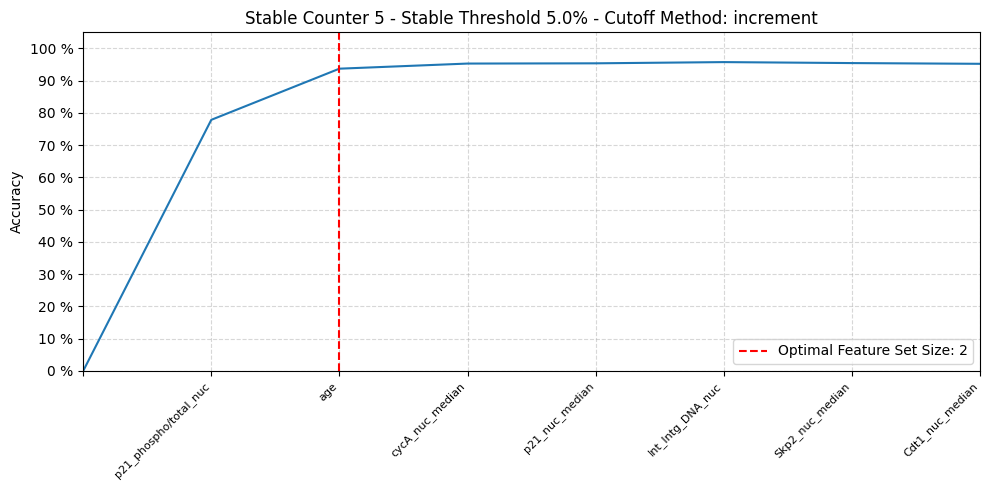

In [13]:
#defines which features to use for training the random forest for feature selection
training_features = adata.var_names

rf_threshold = 0.05

#runs random forest for feature selection
adata = core.random_forest_feature_selection(adata=adata,
                                             training_feature_set= training_features,
                                             training_labels = 'phase',
                                             method = 'RF_min_max',
                                             stable_counter=5,
                                             cutoff_method='increment',
                                             threshold=rf_threshold,
                                             feature_set_name=f'RMM_PROL_{rf_threshold}')

In [14]:
#defines which features to use for training the random forest for feature selection
training_features = adata.var_names

num_features = 4

#runs random forest for feature selection
adata = core.random_forest_feature_selection(adata=adata,
                                             training_feature_set= training_features,
                                             training_labels = 'phase',
                                             method = f'RF_min_{num_features}',
                                             feature_set_name=f'RM_{num_features}_fs')


Classification Report for RF model trained with given feature set
##################################################################

              precision    recall  f1-score   support

          G1       0.99      0.99      0.99       722
          G2       0.94      0.90      0.92       203
           S       0.95      0.97      0.96       399

    accuracy                           0.97      1324
   macro avg       0.96      0.95      0.96      1324
weighted avg       0.97      0.97      0.97      1324


Classification Report for RF model trained with given feature set
##################################################################

              precision    recall  f1-score   support

          G1       0.99      0.99      0.99       722
          G2       0.86      0.92      0.89       203
           S       0.95      0.91      0.93       399

    accuracy                           0.95      1324
   macro avg       0.93      0.94      0.93      1324
weighted avg       0.95

In [18]:
#Example of how to define your own feature set. Needs to be a list of booleans with the same length as the number of features

#'all_features' could be used in all subsequent functions for the feature_set parameter
adata.var['all_features'] = np.repeat(True, adata.shape[1])

## PHATE hyperparameter search

In [19]:
#creates a layer that has been z-scored
adata.layers[f'z-score'] = st.zscore(adata.X.copy(), axis = 0)

adata

AnnData object with n_obs × n_vars = 8792 × 294
    obs: 'phase', 'phase_colors'
    var: 'RMM_PROL_0.05', 'RM_4_fs', 'all_features'
    layers: 'z-score'

In [20]:
#performs a phate hyperparameter search
phate_param_dict = {'n_components': 2,
                    'knn': [50,75],
                    'gamma': [0,0.5],
                    't': [10,25],
                    'n_jobs': -1,
                    'random_state': 0,
                    'verbose': 0}

param_info_dict = { 'row_label': 'gamma',
                    'col_label': 't',
                    'constant_label': 'knn',
                    'final_figure_dims': (1,2)}

fig_dir = cwd / 'figs'
if not fig_dir.exists():
    fig_dir.mkdir(parents=True)

fig = manifold.perform_phate_hyperparameter_search(adata,
                                        feature_set = f'RMM_PROL_{rf_threshold}',
                                        hyperparam_dict = phate_param_dict,
                                        hyperparam_info_dict = param_info_dict,
                                        layer = f'z-score',
                                        color_name= 'phase_colors',
                                        legend = True,
                                        save_path = fig_dir / 'cc_hyperparameter_search.png',)

Generating hyperparameter search plots:   0%|          | 0/2 [00:00<?, ?it/s]c:\Users\dap182\AppData\Local\anaconda3\envs\test_dtp\lib\site-packages\graphtools\graphs.py:283: RuntimeWarning: Detected zero distance between samples 1231 and 7564, 6554 and 6850. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
c:\Users\dap182\AppData\Local\anaconda3\envs\test_dtp\lib\site-packages\graphtools\graphs.py:283: RuntimeWarning: Detected zero distance between samples 1231 and 7564, 6554 and 6850. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
c:\Users\dap182\AppData\Local\anaconda3\envs\test_dtp\lib\site-packages\graphtools\graphs.py:283: RuntimeWarning: Detected zero distance between samples 1231 and 7564, 6554 and 6850. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
c:\Users\dap182\AppData\Local\anaconda3\envs\test_dtp\lib\site-packages\graphtools\graphs.py:283: RuntimeWarni

In [21]:
#example optimal parameters for phate
phate_optimal_parameter_dict = {'t': 10 , 'gamma': 0 , 'knn': 75, 'random_state': 0}

#runs phate with the optimal parameters and saves the results to the anndata object as a obsm key
adata = manifold.run_phate(adata, 
                            feature_set = f'RMM_PROL_{rf_threshold}',
                            phate_param_dict = phate_optimal_parameter_dict,
                            layer = f'z-score',
                            obsm_save_key = 'X_phate')

Calculating PHATE...
  Running PHATE on 8792 observations and 2 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.89 seconds.
    Calculating affinities...


c:\Users\dap182\AppData\Local\anaconda3\envs\test_dtp\lib\site-packages\graphtools\graphs.py:283: RuntimeWarning: Detected zero distance between samples 1231 and 7564, 6554 and 6850. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 0.35 seconds.
  Calculated graph and diffusion operator in 1.28 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.33 seconds.
    Calculating KMeans...
    Calculated KMeans in 2.23 seconds.
  Calculated landmark operator in 4.37 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.30 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.38 seconds.
Calculated PHATE in 9.34 seconds.


In [22]:
adata

AnnData object with n_obs × n_vars = 8792 × 294
    obs: 'phase', 'phase_colors'
    var: 'RMM_PROL_0.05', 'RM_4_fs', 'all_features'
    obsm: 'X_phate'
    layers: 'z-score'

## Useful Plotting Functions 

<Axes: >

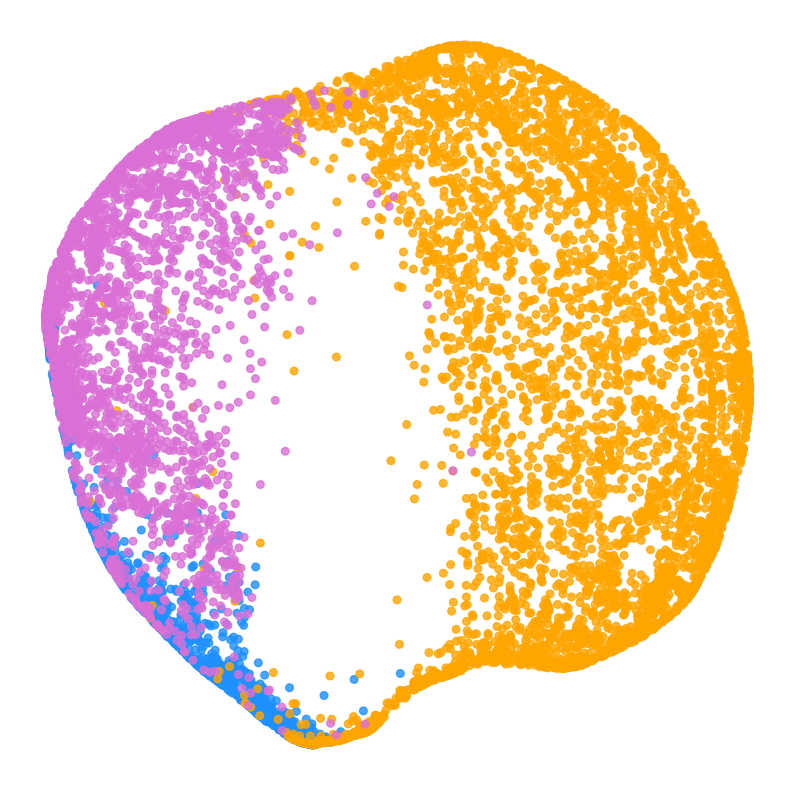

In [23]:
#basic phate plotting function
kwargs = {'s': 30,
            'alpha': 0.8,
            'rasterized': True,
          }

manifold.plot_phate_coords(adata = adata,
                           colors = 'phase_colors',
                           kwargs = kwargs,)

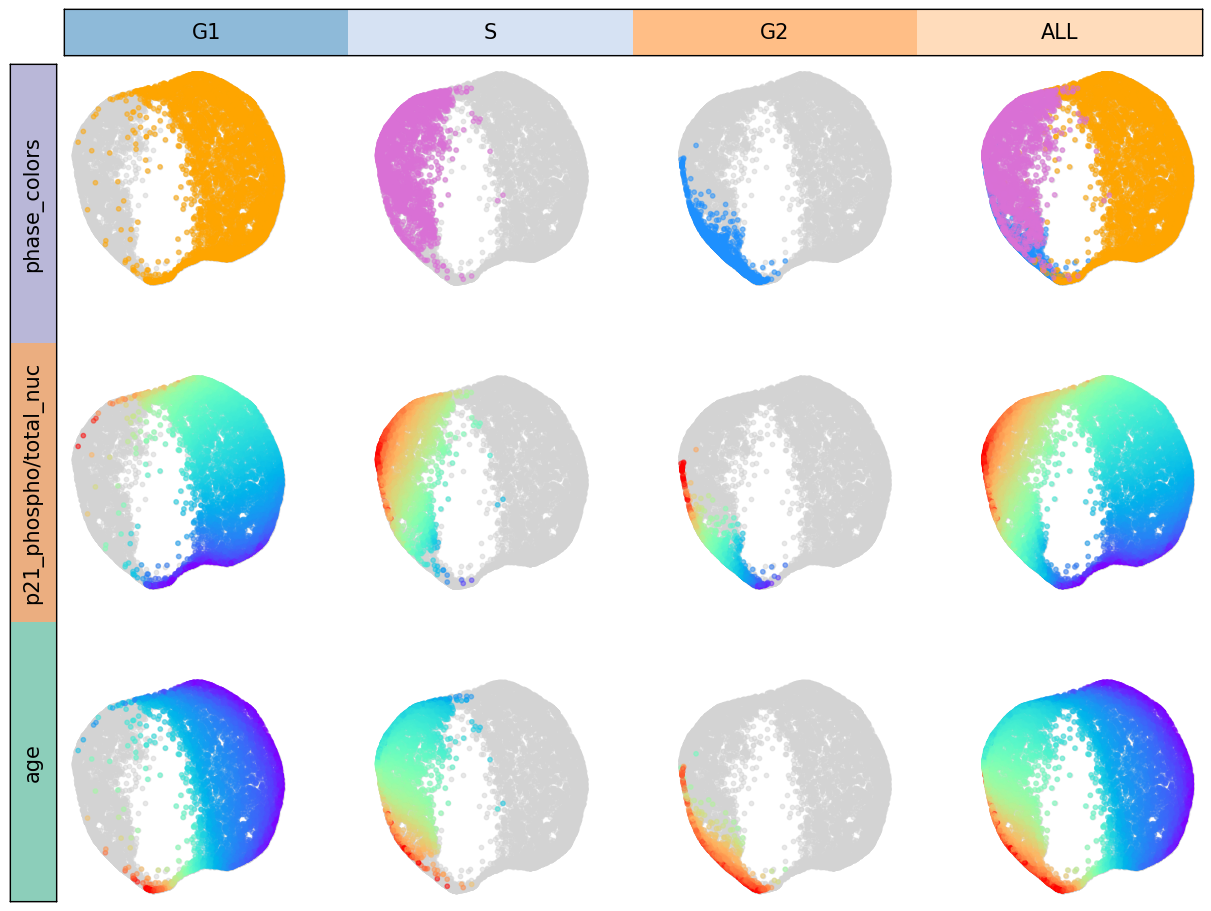

In [24]:
colors = ['phase_colors', 'p21_phospho/total_nuc', 'age']

kwargs = {'s': 10,
            'alpha': 0.5,
            'rasterized': True,
          }

#different permutations of the plot_row_partitions function
plot.plot_row_partitions(adata,
                         obs_search_term = 'phase', 
                         colors = colors,
                         plot_all = True,
                         column_labels = ['G1', 'S', 'G2', 'ALL'], 
                         unit_size =3,
                         kwargs = kwargs)
